# Optimización de hiperparámetros de SVM utilizando Particle Swarm Optimization (PSO)

## Algoritmos Evolutivos I - Carrera de Especialización en Inteligencia Artificial (CEIA) - UBA
### Alumna: Ing. Natalia Espector - nataliaespector@gmail.com
### Dataset: Breast Cancer Wisconsin *(scikit-learn)*


## 1. Introducción

En este trabajo se propone realizar la optimización de hiperparámetros de Support Vector Machine (SVM) para clasificación mediante Particle Swarm Optimization (PSO). Se realizará una búsqueda de los valores de C y gamma que maximizan la accuracy del modelo. Los resultados del análisis se compararán con los parámetros obtenidos a través de RandomizedSearchCV, que se considerará como baseline.

Asimismo, se analizará el impacto del factor de inercia (w) del modelo PSO en el desempeño del modelo y su velocidad de convergencia.

Este trabajo se desarrollará utilizando el dataset Breast Cancer Wisconsin, disponible en *scikit-learn*, que cuenta con diversos parámetros de tumores de mama asociados a su tamaño, forma y composición, y los clasifica como benignos o malignos.

Se decidió utilizar una implementación propia del algoritmo PSO en lugar de la librería *pyswarm*, para tener una mayor versatilidad para obtener la curva de convergencia.

Importación de librerías

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from scipy.stats import loguniform

Carga del dataset y análisis general

In [167]:
X, y = load_breast_cancer(as_frame=True, return_X_y=True)

In [168]:
X_df = pd.DataFrame(X)
Y_df = pd.DataFrame(y)
df = pd.concat([X_df, Y_df], axis=1)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [170]:
print("Cantidad de valores duplicados:",df.duplicated().sum())

Cantidad de valores duplicados: 0


In [171]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [172]:
Y_df.value_counts()
# siendo 1 = benigno y 0 = maligno

,count
target,
1,357
0,212


Se observa que el dataset cuenta con 569 observaciones, 30 características, y una columna de salida con la clasificación 1: benigno y 0: maligno. No se observan valores nulos ni duplicados.

## 2. Configuración general

Se definen algunas variables generales, como el valor de la semilla, los límites inferior y superior para los parámetros C y Gamma, y la cantidad de folds que se utilizarán para la validación cruzada.

Dado que los valores de los parámetros C y gamma actúan exponencialmente sobre el modelo y pueden estar distribuidos en varios órdenes de magnitud, se decide trabajar en escala logarítmica. Se establecerán como límites para la búsqueda:
* C entre [$10^{-2}$,$10^{3}$]
* Gamma entre [$10^{-4}$,$10^{1}$]

Se carga nuevamente el dataset sin encabezados, se define la validación cruzada, y luego se definen la función objetivo y la función PSO.

In [173]:
# Semilla
SEED = 42
np.random.seed(SEED)

# Rangos en log10 para (C, gamma)
# C en [1e-2, 1e3]
limite_inf_logC = -2  # limite inferior de busqueda
limite_sup_logC = 3  # limite superior de busqueda
# gamma en [1e-4, 1e1]
limite_inf_logG = -4  # limite inferior de busqueda
limite_sup_logG = 1  # limite superior de busqueda
limites = np.array([[limite_inf_logC, limite_sup_logC], [limite_inf_logG, limite_sup_logG]])

# Dataset sin encabezados
X, y = load_breast_cancer(return_X_y=True)

# Cross-validation
CV_FOLDS = 5
cv_split = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=SEED)

Función objetivo: recibe los parámetros log(C) y log(gamma), X, y y cv_split.Se crea un pipeline, en el que primero estandariza y luego aplica SVC (Support Vector Machine para clasificación) con los parámetros C y gamma recibidos. Luego se calcula la accuracy para cada fold, y finalmente se devuelve el valor promedio de esa accuracy (en valor negativo, ya que PSO minimiza).

In [174]:
# ========== Función objetivo (devuelve -accuracy CV) ==========
def objective_log_space(params, X=X, y=y, cv=cv_split):
    logC, logGamma = params
    C = 10 ** logC
    gamma = 10 ** logGamma

    model = make_pipeline(
        StandardScaler(),
        SVC(C=C, gamma=gamma, kernel='rbf', random_state=SEED)
    )
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    return -scores.mean()  # PSO minimiza

Función PSO:

La función se definió tomando como base un ejemplo visto en clase. Se realizaron algunas modificaciones sobre la misma para tener mayor versatilidad para utilizarla en el desarrollo del trabajo. Las principales modificaciones consistieron en:
* Adaptarla para que pueda recibir límites distintos para los parámetros C y gamma
* Permite recibir un enjambre inicial de partículas (posiciones y velocidades), a efectos de poder hacer comparaciones modificando parámetros de la función y analizando los resultados para un mismo enjambre inicial.
* Permite inicializar las velocidades con valores distintos a cero
* Incorpora el "clip" en velocidad además de posición, para ralentizar la velocidad de convergencia
* Devuelve los valores de la función fitness en cada iteración, para poder graficar luego la curva de convergencia

In [175]:
def funcion_PSO_2D(funcion_obj, limites, w=0.5, c1=2.0, c2=2.0, vmax=0.3, num_particulas=10, cantidad_iteraciones=10, particulas_init=None, velocidades_init=None, imprimir_resultados=1):
  dim=2

  # Inicialización posiciones
  if particulas_init is None:
    particulas = np.random.uniform(low=limites[:, 0], high=limites[:, 1], size=(num_particulas, dim))
  else:
    particulas = particulas_init.copy()

  # Inicialización velocidades
  if velocidades_init is None:
    velocidades = np.zeros((num_particulas, dim))  # inicializacion de la matriz de velocidades en cero
  else:
    velocidades = velocidades_init.copy()

  #particulas = np.random.uniform(low=limites[:, 0], high=limites[:, 1], size=(num_particulas, dim))
  #velocidades = np.zeros((num_particulas, dim))  # inicializacion de la matriz de velocidades en cero

  # inicializacion de pbest y gbest
  pbest = particulas.copy()  # mejores posiciones personales iniciales

  fitness_pbest = np.empty(num_particulas)  # mejores fitness personales iniciales
  for i in range(num_particulas):
    fitness_pbest[i] = objective_log_space([particulas[i][0], particulas[i][1]])

  gbest = pbest[np.argmin(fitness_pbest)]  # mejor posicion global inicial
  fitness_gbest = np.min(fitness_pbest)  # fitness global inicial

  # busqueda
  historico_fitness_gbest = []  # Lista para almacenar el fitness global en cada iteración

  for iteracion in range(cantidad_iteraciones):
      for i in range(num_particulas):  # iteracion sobre cada partícula
          r1, r2 = np.random.rand(), np.random.rand()  # generacion dos numeros aleatorios

          # actualizacion de la velocidad de la particula en cada dimension
          for d in range(dim):
              velocidades[i][d] = (w * velocidades[i][d] + c1 * r1 * (pbest[i][d] - particulas[i][d]) + c2 * r2 * (gbest[d] - particulas[i][d]))
              velocidades[i][d] = np.clip(velocidades[i][d], -vmax, vmax)  # mantenimiento de las velocidades dentro de los limites

          for d in range(dim):
              particulas[i][d] = particulas[i][d] + velocidades[i][d]  # cctualizacion de la posicion de la particula en cada dimension

              # mantenimiento de las partículas dentro de los limites
              particulas[i][d] = np.clip(particulas[i][d], limites[d, 0], limites[d, 1])


          fitness = objective_log_space([particulas[i][0], particulas[i][1]])  # Evaluacion de la funcion objetivo para la nueva posicion

          # actualizacion el mejor personal
          if fitness < fitness_pbest[i]:
              fitness_pbest[i] = fitness  # actualizacion del mejor fitness personal
              pbest[i] = particulas[i].copy()  # actualizacion de la mejor posicion personal

              # actualizacion del mejor global
              if fitness < fitness_gbest:
                  fitness_gbest = fitness  # actualizacion del mejor fitness global
                  gbest = particulas[i].copy()  # actualizacion de la mejor posicion global

      historico_fitness_gbest.append(fitness_gbest) # Almacenar el mejor fitness global de la iteración

      # imprimir el mejor global en cada iteracion
      if imprimir_resultados:
        print(f"Iteración {iteracion + 1}: Mejor posición global {gbest}, Valor {fitness_gbest}")

  # resultado
  solucion_optima = gbest  # mejor posicion global final
  valor_optimo = fitness_gbest  # mejor fitness global final

  if imprimir_resultados:
    print("\nSolucion optima (x, y):", solucion_optima)
    print("Valor optimo:", valor_optimo)

  return solucion_optima, valor_optimo, historico_fitness_gbest

## 3. Modelo baseline

Como modelo baseline, se utiliza RandomizedSearchCV utilizando un mismo pipeline (estandarización + SVC), mismo cv_split, misma semilla y mismos límites para la búsqueda de C y gamma. Finalmente se muestran los resultados obtenidos para los parámetros y su accuracy.

In [176]:
# ========== RandomizedSearchCV (baseline) ==========
pipe = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=SEED))
param_distributions = {
    # loguniform(a, b): distribución en [a, b] en escala log
    'svc__C': loguniform(1e-2, 1e3),
    'svc__gamma': loguniform(1e-4, 1e1),
}
rs = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='accuracy',
    cv=cv_split,
    n_jobs=-1,
    random_state=SEED
)
rs.fit(X, y)
acc_rs = rs.best_score_
C_rs = rs.best_params_['svc__C']
G_rs = rs.best_params_['svc__gamma']
logC_rs, logG_rs = np.log10(C_rs), np.log10(G_rs)

print(f"[Randomized] Accuracy CV ≈ {acc_rs:.4f}")
print(f"[Randomized] Mejor (C, gamma): C={C_rs:.6g}, gamma={G_rs:.6g}")
print(f"[Randomized] Mejor (log10 C, log10 gamma): ({logC_rs:.3f}, {logG_rs:.3f})")

[Randomized] Accuracy CV ≈ 0.9789
[Randomized] Mejor (C, gamma): C=4.10832, gamma=0.0137311
[Randomized] Mejor (log10 C, log10 gamma): (0.614, -1.862)


## 4. Modelo PSO y análisis del factor de inercia (w)

Se inicializan los parámetros, el enjambre inicial (posiciones de partículas y velocidades) y los 3 valores de w a analizar (0.3, 0.7 y 0.9). Luego se grafica la curva de convergencia para cada caso.

In [191]:
c1 = 2.0  # componente cognitivo
c2 = 1.8  # componente social
vmax=0.3
num_particulas = 10  # numero de particulas
cantidad_iteraciones = 20  # maximo numero de iteraciones

dim=2
particulas=np.random.uniform(low=limites[:, 0], high=limites[:, 1], size=(num_particulas, dim))
velocidades=(np.random.rand(num_particulas, dim) * 2 - 1) * 0.1

# Curva de convergencia para w=0.3, w=0.7, w=0.9
w_values = [0.3, 0.7, 0.9]

Iteración 1: Mejor posición global [ 1.64389027 -2.38234794], Valor -0.9789163173420278
Iteración 2: Mejor posición global [ 1.64389027 -2.38234794], Valor -0.9789163173420278
Iteración 3: Mejor posición global [ 1.64389027 -2.38234794], Valor -0.9789163173420278
Iteración 4: Mejor posición global [ 1.64389027 -2.38234794], Valor -0.9789163173420278
Iteración 5: Mejor posición global [ 1.64389027 -2.38234794], Valor -0.9789163173420278
Iteración 6: Mejor posición global [ 1.64389027 -2.38234794], Valor -0.9789163173420278
Iteración 7: Mejor posición global [ 1.64389027 -2.38234794], Valor -0.9789163173420278
Iteración 8: Mejor posición global [ 1.64389027 -2.38234794], Valor -0.9789163173420278
Iteración 9: Mejor posición global [ 1.1383311  -1.87051901], Valor -0.9824250892718522
Iteración 10: Mejor posición global [ 1.1383311  -1.87051901], Valor -0.9824250892718522
Iteración 11: Mejor posición global [ 1.04830523 -1.78047226], Valor -0.9841794752367644
Iteración 12: Mejor posición g

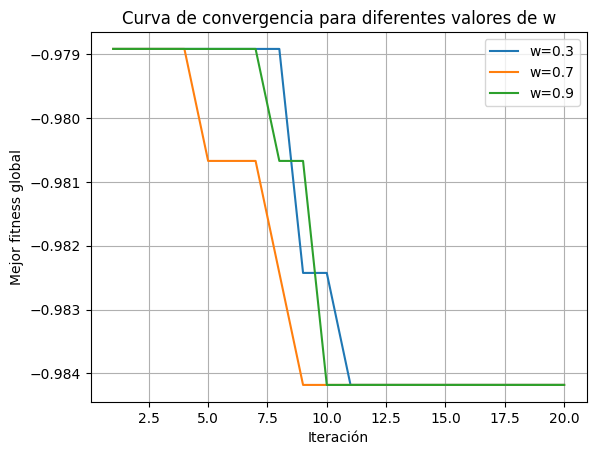

In [192]:
solucion_optima=[None] * len(w_values)
valor_optimo=[None] * len(w_values)
i=0

for w in w_values:
    solucion_optima[i], valor_optimo[i], historico_fitness_gbest = funcion_PSO_2D(objective_log_space, limites, w, c1, c2, vmax, num_particulas, cantidad_iteraciones, particulas_init=particulas, velocidades_init=velocidades)
    plt.plot(range(1, cantidad_iteraciones + 1), historico_fitness_gbest, label=f'w={w}')
    i+=1

plt.title('Curva de convergencia para diferentes valores de w')
plt.xlabel('Iteración')
plt.ylabel('Mejor fitness global')
plt.legend()
plt.grid(True)
plt.show()

En la figura se muestra la curva de convergencia del PSO para tres valores del factor de inercia w. Se realizan diferentes corridas variando el valor de w, con el mismo enjambre inicial (posiciones y velocidades) y la misma semilla aleatoria. Si bien el resultado presenta variaciones entre ejecuciones debido al carácter estocástico del algoritmo, se observa un comportamiento esperable de las curvas en función de w.

El parámetro w controla el compromiso entre exploración y explotación del enjambre: valores bajos de w (0.3) favorecen la explotación temprana (movimientos más cortos y rápidos hacia el mejor global), mientras que valores altos de w (0.9) promueven la exploración (movimientos más amplios que permiten recorrer con mayor amplitud el espacio de búsqueda antes de estabilizarse). El valor de w=0.7, recomendado en la literatura, muestra un comportamiento más balanceado entre exploración y explotación.

En todos los casos, al tratarse de un problema relativamente simple, la convergencia final ocurre en pocas iteraciones, aunque con dinámicas distintas según el valor de w.

Es importante destacar que en todos los casos el valor de accuracy es de 0.9842, superando el obtenido con el modelo baseline de 0.9789.

Durante el desarrollo de este punto, surgieron algunos puntos importantes que llevaron a las modificaciones del algoritmo inicial. Por un lado, fue necesario adaptarlo para recibir un enjambre inicial de partículas y velocidades, de manera de utilizar el mismo en todas las corridas y que la comparación tuviera sentido.

Por otro lado, al tratarse de un problema sencillo, la convergencia se alcanzaba rápidamente, y no se veía el impacto del factor de inercia en las curvas. Por esta razón, se incluyeron algunas adaptaciones en el algoritmo como la reducción de la cantidad de partículas, la inicialización de velocidad distinta de cero, el clip de velocidad para que no tuviera valores demasiado altos, y el ajuste del valor de c2 para dar menor peso al global best. Con estas modificaciones, fue posible tener una velocidad más lenta de convergencia de manera de observar más adecuadamente la diferencia entre las curvas.

## 5. Comparación de resultados entre modelos baseline y PSO

A continuación, se muestran los resultados obtenidos para el modelo baseline y los 3 modelos PSO con diferente w en un mapa de calor, de manera de poder ver en forma gráfica las diferentes combinaciones de C y gamma obtenidas en cada caso y su valor de accuracy.

In [193]:
# Función para obtener accuracy (positivo) en log-espacio
def accuracy_log_space(logC, logGamma, X=X, y=y, cv=cv_split):
    return -objective_log_space((logC, logGamma), X=X, y=y, cv=cv)

[Plot] Evaluando superficie (demora unos segundos)...


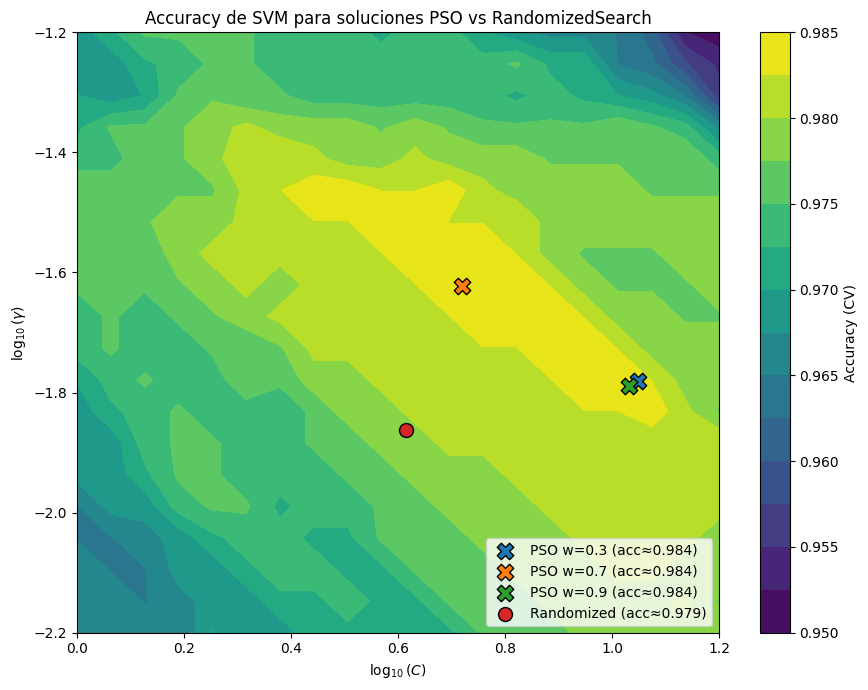

In [194]:
# ========== Mapa de calor de accuracy en (logC, logGamma) ==========
GRID_N=20
logC_lin = np.linspace(0, 1.2, GRID_N)
logG_lin = np.linspace(-2.2, -1.2, GRID_N)
LC, LG = np.meshgrid(logC_lin, logG_lin)

Z = np.empty_like(LC, dtype=float)
# Evaluación de accuracy en la grilla
print("[Plot] Evaluando superficie (demora unos segundos)...")
for i in range(GRID_N):
    for j in range(GRID_N):
        Z[i, j] = accuracy_log_space(LC[i, j], LG[i, j])


plt.figure(figsize=(9, 7))
cont = plt.contourf(LC, LG, Z, levels=15)
cbar = plt.colorbar(cont)
cbar.set_label('Accuracy (CV)')

# Marcar soluciones
plt.scatter(solucion_optima[0][0], solucion_optima[0][1], marker='X', s=140, edgecolor='black', linewidths=1.0, label=f'PSO w={w_values[0]} (acc≈{-valor_optimo[0]:.3f})')
plt.scatter(solucion_optima[1][0], solucion_optima[1][1], marker='X', s=140, edgecolor='black', linewidths=1.0, label=f'PSO w={w_values[1]} (acc≈{-valor_optimo[1]:.3f})')
plt.scatter(solucion_optima[2][0], solucion_optima[2][1], marker='X', s=140, edgecolor='black', linewidths=1.0, label=f'PSO w={w_values[2]} (acc≈{-valor_optimo[2]:.3f})')
plt.scatter(logC_rs,  logG_rs,  marker='o', s=100, edgecolor='black', linewidths=1.0, label=f'Randomized (acc≈{acc_rs:.3f})')

# Etiquetas y estética
plt.xlabel(r'$\log_{10}(C)$')
plt.ylabel(r'$\log_{10}(\gamma)$')
plt.title('Accuracy de SVM para soluciones PSO vs RandomizedSearch')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

A partir del gráfico, podemos observar las distintas combinaciones de soluciones obtenidas mediante el algoritmo PSO y la obtenida mediante RandomizedSearch. Esto nos permite ver de manera gráfica que las 3 soluciones PSO se encuentran en una región de máxima accuracy, mientras que la solución encontrada con Randomized Search se aleja de la zona mencionada.

## 6. Análisis de variabilidad de resultados en algoritmo PSO

Se realizaron 20 corridas independientes para el algoritmo PSO con cada factor de inercia analizado y se almacena el valor final de la accuracy en cada caso. Con estos datos, se realizó un gráfico de boxplot para comparar los resultados obtenidos y analizar la estabilidad y robustez del algoritmo.

Dado que en este caso se busca analizar la variabilidad de los resultados, no se utiliza el mismo enjambre inicial, sino que se inicializa de manera distinta cada vez, simulando un uso más real del algoritmo.

In [219]:
cantidad_iteraciones = 10
num_runs = 20

resultados = {w: [] for w in w_values}

for w in w_values:
  for run in range(num_runs):
    _, valor_optimo, _ = funcion_PSO_2D(objective_log_space, limites, w, c1, c2, vmax, num_particulas, cantidad_iteraciones, particulas_init=None, velocidades_init=None,imprimir_resultados=0)
    resultados[w].append(-valor_optimo)

data = [resultados[w] for w in w_values]

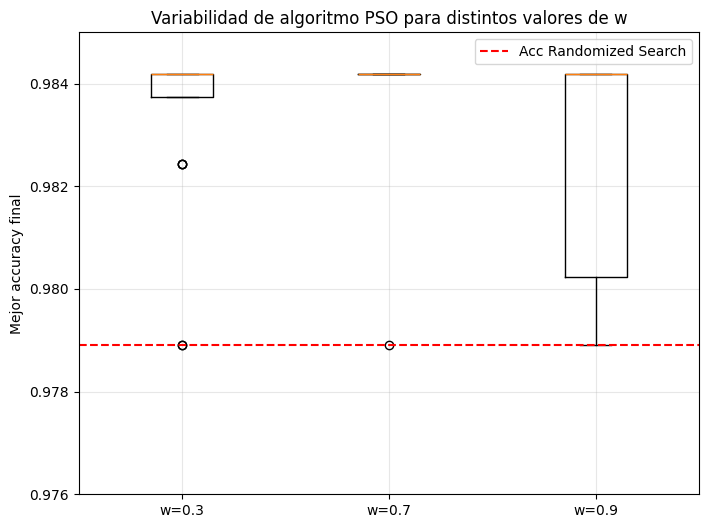

In [220]:
plt.figure(figsize=(8,6))
plt.boxplot(data, tick_labels=[f"w={w}" for w in w_values])
plt.axhline(y=acc_rs, color='r', linestyle='--', label='Acc Randomized Search')
plt.ylabel("Mejor accuracy final")
plt.title("Variabilidad de algoritmo PSO para distintos valores de w")
plt.ylim(0.976, 0.985)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [221]:
rows = []
for w, vals in resultados.items():
    vals = np.array(vals)
    rows.append({
        "w": w,
        "Mínimo": vals.min(),
        "Promedio": vals.mean(),
        "Máximo": vals.max(),
        "Desv. Est.": vals.std()
    })

tabla = pd.DataFrame(rows).set_index("w")
print(tabla.round(4))

     Mínimo  Promedio  Máximo  Desv. Est.
w                                        
0.3  0.9789    0.9834  0.9842      0.0016
0.7  0.9789    0.9839  0.9842      0.0011
0.9  0.9789    0.9826  0.9842      0.0023


En la figura se muestra el boxplot del mejor valor de accuracy obtenido por el PSO para diferentes valores del factor de inercia w, a partir de 20 corridas independientes del algoritmo. La línea naranja en cada boxplot indica la mediana, mientras que los círculos representan valores atípicos (outliers). Se incluye también, como referencia, el valor alcanzado mediante Randomized Search (línea punteada roja).

Luego se presenta la tabla con los valores mínimo, máximo, promedio y desviación estándar para cada w.

Se observa que la mediana del accuracy final es prácticamente la misma para los tres casos, lo que indica que PSO tiende a converger a soluciones de similar calidad en este problema. Sin embargo, al analizar la media, puede verse que w=0.7 obtiene un valor promedio levemente mayor al resto y con una desviación menor, evidenciando un comportamiento más estable.  

En cuanto a la variabilidad, se observan diferencias claras entre las configuraciones evaluadas. Para valores bajos de w (w=0.3) se obtienen resultados estables pero con mayor riesgo de convergencia prematura. Para valores altos de w (w=0.9) se promueve una mayor exploración del espacio de búsqueda, a costa de resultados más dispersos. El caso intermedio (w=0.7) resulta el más robusto, logrando un buen equilibrio entre exploración y explotación, mostrando la menor variabilidad y el valor promedio más alto.

Finalmente, al comparar con Randomized Search, PSO logra igualar o superar el valor de accuracy en la gran mayoría de las corridas, evidenciando su capacidad para encontrar hiperparámetros competitivos.

## 7. Conclusiones finales

En este trabajo se abordó la optimización de hiperparámetros de un modelo Support Vector Machine para clasificación, empleando el algoritmo *Particle Swarm Optimization (PSO)* sobre el dataset **Breast Cancer Wisconsin**, utilizando *accuracy* como métrica objetivo. Los resultados se compararon contra un *baseline* obtenido mediante *andomized Search*.

Se desarrolló una implementación propia para PSO, sin utilizar librerías específicas como *pyswarm*, para contar con mayor control sobre el algoritmo y facilitar el análisis de su comportamiento.

Se estudió el impacto del factor de inercia (w) en la curva de convergencia del algoritmo. Se observó que valores bajos de w favorecen la explotación temprana, produciendo trayectorias más cortas hacia el óptimo, mientras que valores altos promueven una exploración más amplia y mayor variabilidad entre corridas. Con
w=0.7 se alcanzó el mejor compromiso entre exploración y explotación, logrando además el mayor valor de accuracy (0.9842).

La comparación visual de las soluciones en un mapa de calor evidenció que todas las ejecuciones de PSO convergen hacia la misma región de alta accuracy, mientras que la solución obtenida por Randomized Search se encuentra más alejada del óptimo.

Dada la variabilidad encontrada en las diferentes corridas del algoritmo, se realizaron 20 corridas independientes para cada valor de w, analizando la distribución de los mejores resultados obtenidos. Los experimentos mostraron que tanto w bajos como altos presentan mayor dispersión, mientras que w=0.7 ofrece mayor estabilidad y el mejor desempeño promedio, confirmando la importancia de un equilibrio exploración–explotación. Además, se observó que PSO superó a Randomized Search en la amplia mayoría de las corridas.

Como trabajo a futuro, podrían explorarse otras métricas de evaluación en lugar de accuracy (como precisión, recall o f1-score), analizar variantes del algoritmo utilizando un factor de inercia adaptativo y aplicar la metodología a problemas de mayor dimensión o modelos más complejos.

En conclusión, si bien el caso analizado es relativamente simple, el trabajo permitió establecer una metodología para la aplicación de PSO en la optimización de hiperparámetros de modelos de clasificación, sentando las bases para su utilización en escenarios más exigentes.